<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_fault_network/blob/main/report_files/02_Adding%20Bulabulling%20North%20and%20South%20and%20abutting%20faults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_faults
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [3]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

# Imports

In [4]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM =  r"./data/dem.tif"

In [5]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [6]:
updated_data = pd.read_csv("./data/LoopStructural_data/updated_data.csv")
updated_oris = pd.read_csv("./data/LoopStructural_data/updated_oris.csv")

# Add seismic data, 
### it is assumed that both the Northern and the Southern section of the Bulabulling Fault have the same dip

In [7]:
Bull_seismic = gpd.read_file(os.path.join(path_seismic, "Bullabulling_fault.shp"))

Bull_seismic = Bull_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
Bull_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

Bull_seismic['fault_name'] = 'Bullabulling Fault'

## Add northern section

In [8]:
Bull_N_pts = gpd.read_file(os.path.join(path_shp, "Bullabulling_North.shp"))

Bull_N_pts = pd.DataFrame({'X': Bull_N_pts.geometry.x, 
                         'Y': Bull_N_pts.geometry.y, 
                         'Z': Bull_N_pts.DEM_main})

Bull_N_pts['fault_name'] = 'Bullabulling North Fault'

updated_data_BN = pd.concat([Bull_seismic, Bull_N_pts])


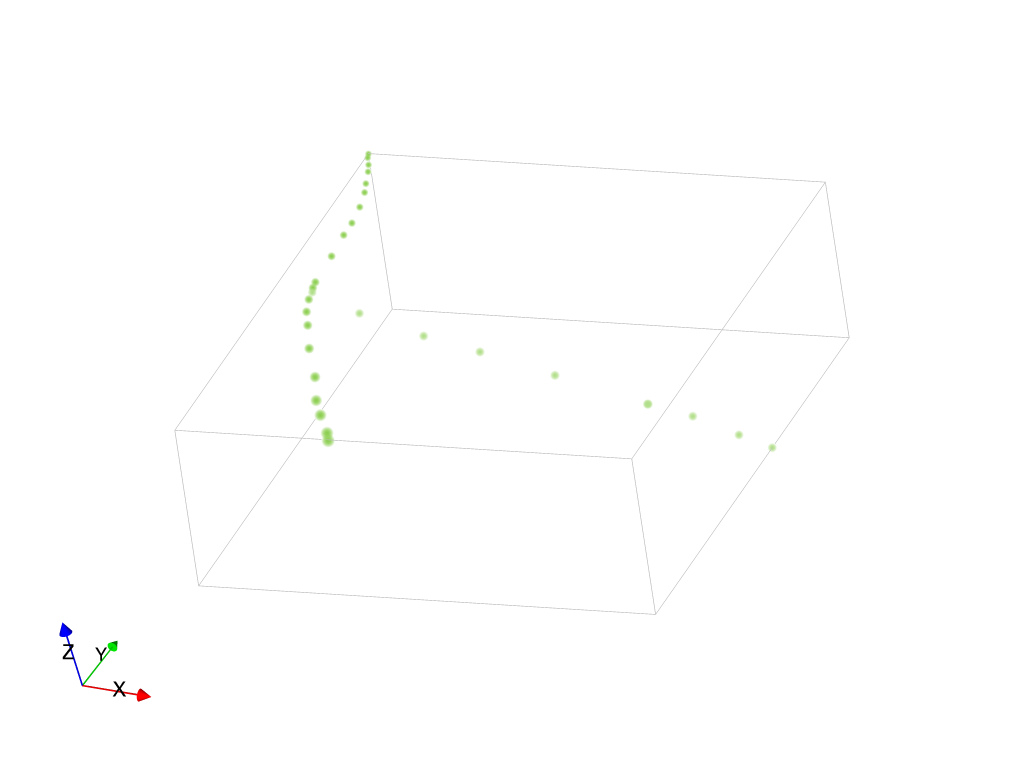

In [9]:
view = LavaVuModelViewer()

bbox = np.array([214794.5029269870719872, 6501887.2589999996125698, -40000, 
                 400411.4882275541312993, 6653021.2462467299774289, 5000]).reshape(2, 3)

view.bounding_box = bbox

view.add_points(Bull_seismic[['X', 'Y', 'Z']], name = 'Bullabulling seismic', pointsize = 10, colour = '#b2df8a')
view.add_points(Bull_N_pts[['X', 'Y', 'Z']], name = 'Bulabulling surface', pointsize = 10, colour = darken_color('#b2df8a'))

view.rotation = [-59.14857864379883, -21.383867263793945, -3.5806798934936523]

view.display()

In [10]:
# calculate the gradient constraints using the tangents (because only one series of points in seismic)

In [11]:
tangent_xy = (Bull_N_pts[['X', 'Y', 'Z']].iloc[0, :].to_numpy() - Bull_N_pts[['X', 'Y', 'Z']].iloc[-1, :].to_numpy())
norm_xy = tangent_xy / np.linalg.norm(tangent_xy)

minZ = Bull_seismic[Bull_seismic['Z'] == Bull_seismic['Z'].min()][['X', 'Y', 'Z']].to_numpy()
maxZ = Bull_seismic[Bull_seismic['Z'] == Bull_seismic['Z'].max()][['X', 'Y', 'Z']].to_numpy()

tangent_z2 = maxZ - minZ
norm_z = tangent_z2/np.linalg.norm(tangent_z2)

CP = np.cross(norm_xy, norm_z)

In [12]:
ori_BN = pd.DataFrame(CP)
ori_BN['fault_name'] = "Bullabulling North Fault"
ori_BN.columns = ['gx', 'gy', 'gz', 'fault_name']

ori_BN['X'] = Bull_N_pts['X'].mean()
ori_BN['Y'] = Bull_N_pts['Y'].mean()
ori_BN['Z'] = Bull_seismic['Z'].mean()

In [13]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

processor = ProcessInputData(fault_locations = updated_data_BN, 
                             fault_orientations = ori_BN,
                             origin=origin, maximum=maximum)

C:\Users\angel\anaconda3\envs\new_loop\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


In [14]:
model = GeologicalModel(origin, maximum)

model.data = processor.data

model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4)

tang2 = np.tile(tangent_z2[0],(model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

model.update(verbose = True)

Updating geological model. There are: 
 3                     geological features that need to be interpolated



  0%|          | 0/3 [00:00<?, ?it/s]

Model update took: 1.503166675567627 seconds



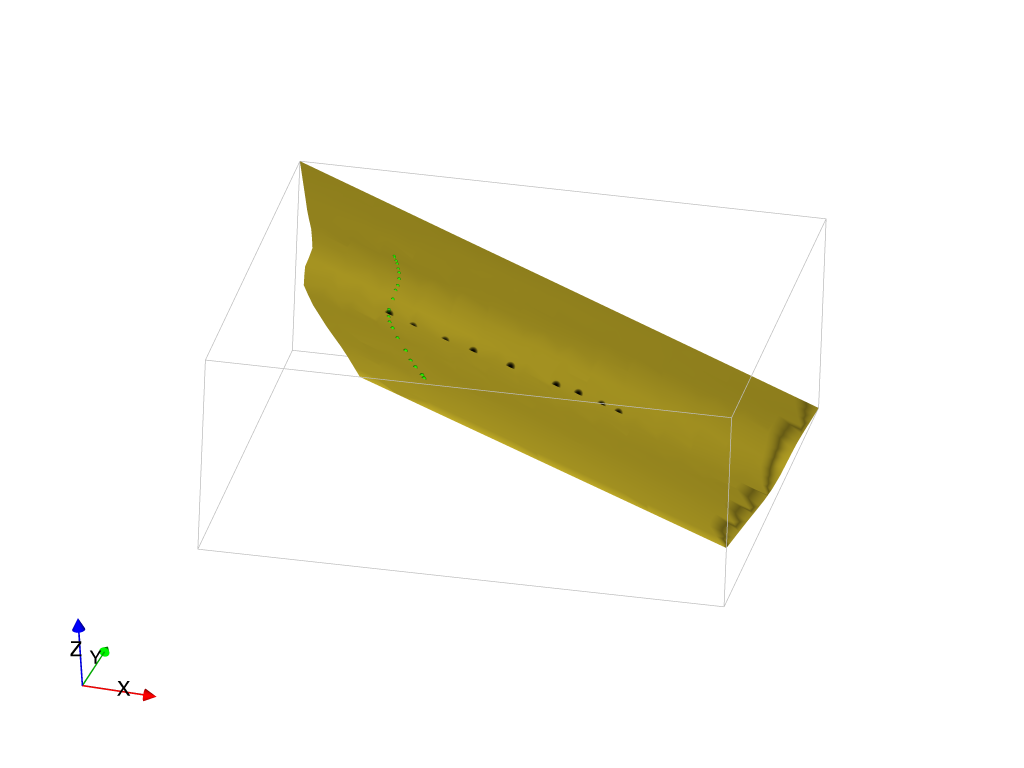

In [15]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Bullabulling North Fault'], colours = ['#ffe333'], value = 0)

view.add_data(model['Bullabulling North Fault'][0])

view.add_points(Bull_seismic[['X', 'Y', 'Z']], name = 'Bullabulling', pointsize = 10)

view.rotation = [-65.9224853515625, -8.936570167541504, -6.251590728759766]
view.display()

### Add Northern abutting fault

In [16]:
# Add abutting fault North for Bullabulling
N_Bulla = gpd.read_file(os.path.join(path_shp, "Bullab_abutting_N_pts_elevation.shp"))

N_Bulla = pd.DataFrame({'X': N_Bulla.geometry.x, 
                   'Y': N_Bulla.geometry.y, 
                   'Z': N_Bulla.DEM_main})

N_Bulla['fault_name'] = "Bulla_Abut_North"

In [17]:
# make this vertical

ori = []
centre = N_Bulla[["X", "Y", "Z"]].mean().to_numpy().tolist()
tangent = (N_Bulla[["X", "Y", "Z"]].to_numpy()[0, :]  - N_Bulla[["X", "Y", "Z"]].to_numpy()[-1, :])
norm = tangent / np.linalg.norm(tangent)
norm = norm.dot(np.array([[0, 1, 0], [0, 0, 0], [0, 0, 1]]))

ori = []
ori.append(["Bulla_Abut_North", *centre, *norm])
ori = pd.DataFrame(ori, columns=["fault_name", "X", "Y", "Z", "gx", "gy", "gz"])

In [18]:
updated_data_1 = pd.concat([updated_data_BN, N_Bulla])
updated_ori = pd.concat([ori_BN, ori])

In [19]:
processor = ProcessInputData(fault_locations = updated_data_1, fault_orientations = updated_ori,
                             origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4, cpw = .05)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4)

tang2 = np.tile(tangent_z2[0],(model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])

model.update(verbose=True)

C:\Users\angel\anaconda3\envs\new_loop\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 6                     geological features that need to be interpolated



  0%|          | 0/6 [00:00<?, ?it/s]

Model update took: 1.6286396980285645 seconds


Object exists: seismic



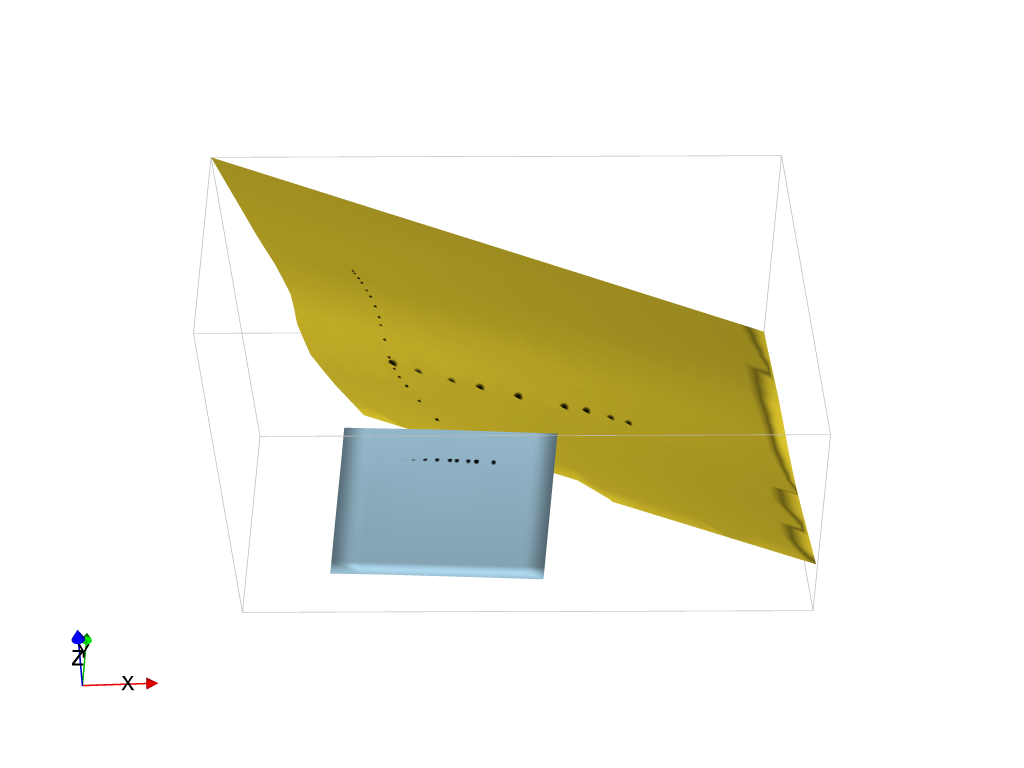

In [20]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Bulla_Abut_North'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#ffe333'], value = 0)

view.add_points(Bull_seismic[['X', 'Y', 'Z']], name = 'Bullabulling', pointsize = 10)
view.add_points(Bull_N_pts[['X', 'Y', 'Z']], name = 'seismic', pointsize = 4)
view.add_points(N_Bulla[['X', 'Y', 'Z']], name = 'seismic', pointsize = 4)

view.rotation = [-52.37095642089844, 7.656054496765137, 0.16374368965625763]
view.display()
# view.interactive()

### Add southern section

In [21]:
Bull_S_pts = gpd.read_file(os.path.join(path_shp, "Bullabulling_South.shp"))

Bull_S_pts = pd.DataFrame({'X': Bull_S_pts.geometry.x, 
                         'Y': Bull_S_pts.geometry.y, 
                         'Z': Bull_S_pts.DEM_main})

Bull_S_pts['fault_name'] = 'Bullabulling South Fault'

new_CP = pd.DataFrame({
    'X': [Bull_S_pts['X'].mean()], 
    "Y": [Bull_S_pts['Y'].mean()], 
    "Z": [Bull_seismic['Z'].mean()], 
    'gx': CP[0][0], 
    'gy': CP[0][1], 
    'gz': CP[0][2], 
    'fault_name': 'Bullabulling South Fault'
    })

updated_ori = pd.concat([updated_ori, new_CP])
updated_data_1 = pd.concat([updated_data_1, Bull_S_pts])

In [22]:
updated_ori

,gx,gy,gz,fault_name,X,Y,Z
0,0.352245,0.102473,0.917071,Bullabulling North Fault,288597.465546,6.618662e+06,-6250.689000
0,0.000000,-0.996646,0.003071,Bulla_Abut_North,291113.118517,6.597520e+06,410.622447
0,0.352245,0.102473,0.917071,Bullabulling South Fault,300390.029744,6.573092e+06,-6250.689000


In [23]:
processor = ProcessInputData(fault_locations = updated_data_1, fault_orientations = updated_ori,
                             origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4, cpw = .05)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4)


tang2 = np.tile(tangent_z2[0],(model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile(tangent_z2[0],(model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)


#Abutting relationships
model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])

model.update(verbose=True)

C:\Users\angel\anaconda3\envs\new_loop\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 9                     geological features that need to be interpolated



  0%|          | 0/9 [00:00<?, ?it/s]

Model update took: 2.0350069999694824 seconds


Object exists: seismic



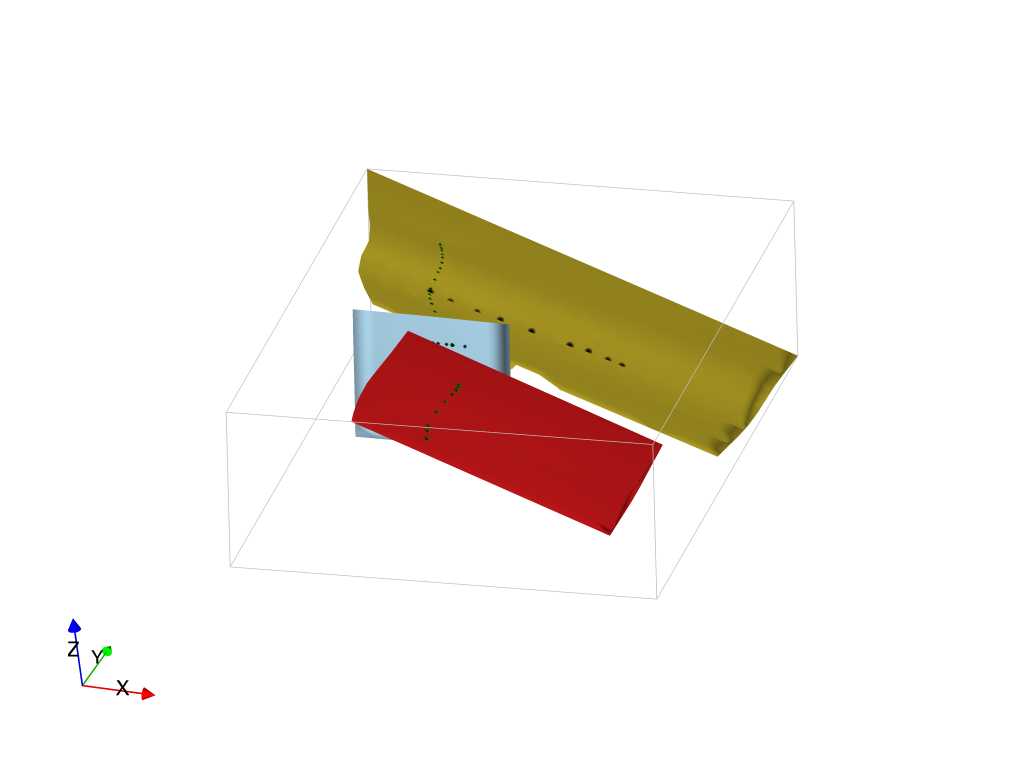

In [24]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Bulla_Abut_North'], colours = ['#a6cee3'], value = 0)

view.add_isosurface(model['Bullabulling North Fault'], colours = ['#ffe333'], value = 0)
view.add_isosurface(model['Bullabulling South Fault'], colours = ['#e31a1c'], value = 0)

view.add_data(model['Bullabulling South Fault'][0])
view.add_data(model['Bullabulling North Fault'][0])

view.add_points(Bull_seismic[['X', 'Y', 'Z']], name = 'Bullabulling', pointsize = 10)
view.add_points(Bull_N_pts[['X', 'Y', 'Z']], name = 'seismic', pointsize = 4)
view.add_points(N_Bulla[['X', 'Y', 'Z']], name = 'seismic', pointsize = 4)
view.add_points(Bull_S_pts[['X', 'Y', 'Z']], name = 'south', pointsize = 4)

view.rotation = [-65.33867645263672, -12.806453704833984, -4.314698696136475]
view.display()
# view.interactive()

## Add southern abutting fault

In [25]:
# Add abutting fault North for Bullabulling
S_Bulla = gpd.read_file(os.path.join(path_shp, "Bullab_abutting_S_pts_elevation.shp"))

# make this vertical
S_Bulla = pd.DataFrame({'X': S_Bulla.geometry.x, 
                   'Y': S_Bulla.geometry.y, 
                   'Z': S_Bulla.DEM_main})

S_Bulla['fault_name'] = "Bulla_Abut_South"

In [26]:
ori = []
centre = S_Bulla[["X", "Y", "Z"]].mean().to_numpy().tolist()
tangent = (S_Bulla[["X", "Y", "Z"]].to_numpy()[0, :] - S_Bulla[["X", "Y", "Z"]].to_numpy()[-1, :])
norm = tangent / np.linalg.norm(tangent)
norm = norm.dot(np.array([[0, 0, 0], [0, 1, 0], [0, 0, 1]]))

ori = []
ori.append(["Bulla_Abut_South", *centre, *norm])
ori = pd.DataFrame(ori, columns=["fault_name", "X", "Y", "Z", "gx", "gy", "gz"])

In [27]:
updated_data_1 = pd.concat([updated_data_1, S_Bulla])
updated_ori = pd.concat([ updated_ori,ori])

In [28]:
processor = ProcessInputData(fault_locations = updated_data_1, fault_orientations = updated_ori,
                             origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4)

# Force the tangents on Bullabulling Fault
tang2 = np.tile(tangent_z2[0],(model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile(tangent_z2[0],(model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)

model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])
model['Bullabulling South Fault'].add_abutting_fault(model['Bulla_Abut_South'])

model.update(verbose=True)

C:\Users\angel\anaconda3\envs\new_loop\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 12                     geological features that need to be interpolated



  0%|          | 0/12 [00:00<?, ?it/s]

Model update took: 2.188159227371216 seconds



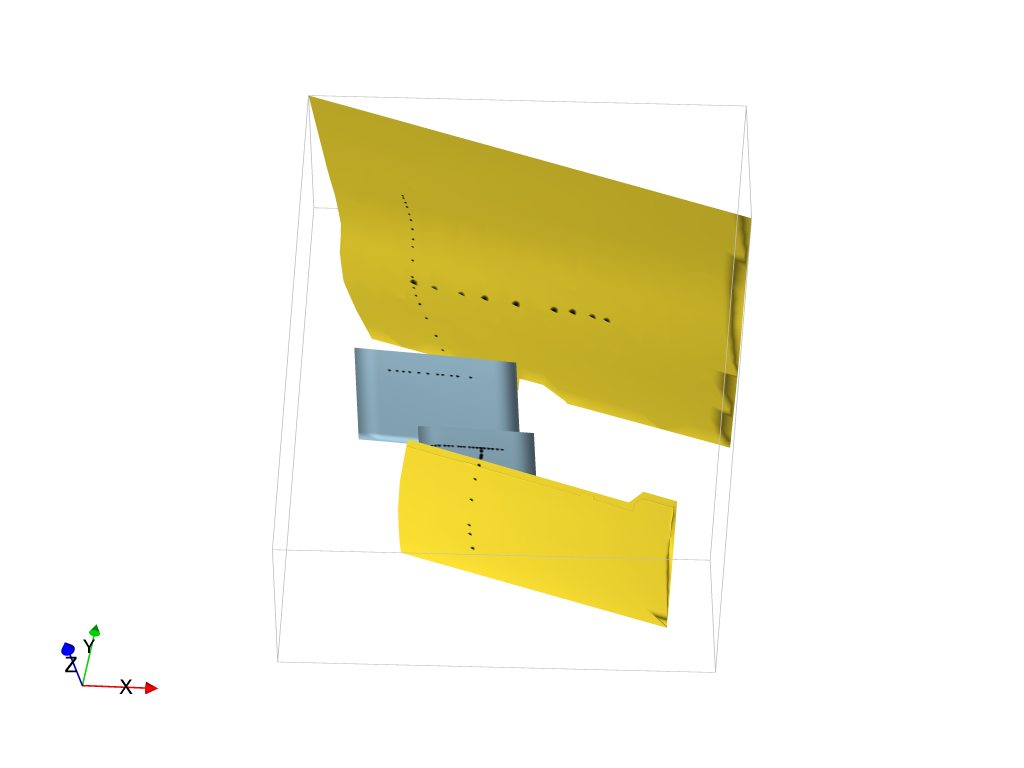

In [29]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Bullabulling South Fault'], colours = ['#ffe333'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#ffe333'], value = 0)

view.add_points(Bull_seismic[['X', 'Y', 'Z']], name = 'seismic', pointsize = 10)
view.add_points(Bull_N_pts[['X', 'Y', 'Z']], name = 'Bulla_Fault_N', pointsize = 4)
view.add_points(N_Bulla[['X', 'Y', 'Z']], name = 'Abut_N', pointsize = 4)
view.add_points(S_Bulla[['X', 'Y', 'Z']], name = 'Abut_S', pointsize = 4)
view.add_points(Bull_S_pts[['X', 'Y', 'Z']], name = 'Bulla_Fault_S', pointsize = 4)

view.rotation = [-41.47319412231445, -3.597280979156494, -1.3734501600265503]
view.display()
# view.interactive()

In [30]:
updated_data = pd.concat([updated_data, updated_data_1])

In [31]:
updated_oris =  pd.concat([updated_oris, updated_ori])

# Join Bulabulling into the whole model

In [35]:
processor = ProcessInputData(fault_locations = updated_data, 
                             fault_orientations = updated_oris,
                             origin = origin, maximum = maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.create_and_add_fault('Ida Fault', displacement = 5, nelements=3e4, force_mesh_geometry = True, 
                          npw=5, cpw = 0.05)

model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=3e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e5)
model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=3e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e5, cpw = 0.2)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e5, cpw = 0.2)


# Force the tangents on Bullabulling Fault
tang2 = np.tile([-30838.81,  -3624.64,  12250.14][0],
                (model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile([-30838.81,  -3624.64,  12250.14][0],
                (model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)

# add abutting relationships
model['Kunanalling Fault'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])
model['Bullabulling South Fault'].add_abutting_fault(model['Bulla_Abut_South'])
model['Bulla_Abut_South'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Bulla_Abut_North'].add_abutting_fault(model['Ida Fault'])

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\new_loop\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 18                     geological features that need to be interpolated



  0%|          | 0/18 [00:00<?, ?it/s]

Model update took: 207.15690279006958 seconds


Object exists: Ida fault data_value_cp
Object exists: Ida fault data_value_cp
Object exists: Kunanalling fault data_value_cp
Object exists: Kunanalling fault data_value_cp
Object exists: Bulla_Abut_South fault data_value_cp
Object exists: Bulla_Abut_South fault data_value_cp
Object exists: Bulla_Abut_North fault data_value_cp
Object exists: Bulla_Abut_North fault data_value_cp
Object exists: Bullabulling South Fault data_value_cp
Object exists: Bullabulling South Fault data_value_cp
Object exists: Bullabulling South Fault data_grad_cp
Object exists: Bullabulling South Fault data_value_cp
Object exists: Bullabulling South Fault data_norm_cp
Object exists: Bullabulling South Fault data_value_cp
Object exists: Bullabulling South Fault data_value_cp



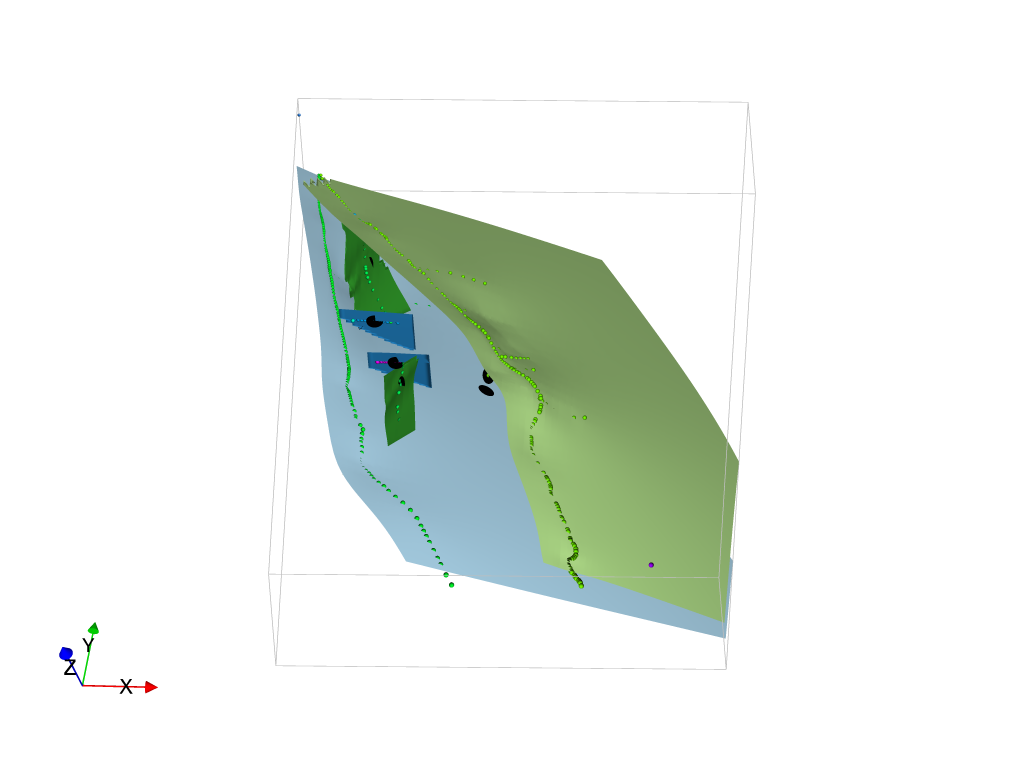

In [36]:
view = LavaVuModelViewer(model)

view.nelements = 1e5
view.nsteps = [100, 100, 100]

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_data(model['Ida Fault'], name = "Ida fault data")
view.add_data(model['Kunanalling Fault'], name = "Kunanalling fault data")
view.add_data(model['Bulla_Abut_South'], name = "Bulla_Abut_South fault data")
view.add_data(model['Bulla_Abut_North'], name = "Bulla_Abut_North fault data")
view.add_data(model['Bullabulling South Fault'], name = "Bullabulling South Fault data")
view.add_data(model['Bullabulling North Fault'], name = "Bullabulling South Fault data")

view.rotation = [-37.933815002441406, -3.9216933250427246, -0.4651407301425934]
view.display()
# view.interactive()

In [34]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_oris.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)